In [11]:
`import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import sys

print(sys.version)
print(torch.__version__)

3.9.13 (main, Oct 13 2022, 21:15:33) 
[GCC 11.2.0]
1.12.1.post201


In [39]:
!pwd

/home/sein/ksc_model


In [12]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import sys

###data augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


batch_size = 200
###train dataset download
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
###specifies the mini batch unit
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
###test dataset download
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
###specifies the mini batch unit
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')




# def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.show()


# # get some random training images
# dataiter = iter(trainloader)
# images, labels = next(dataiter)

# # show images
# imshow(torchvision.utils.make_grid(images))
# # print labels
# print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

Files already downloaded and verified
Files already downloaded and verified


In [13]:
for (X_train, y_train) in trainloader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([200, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([200]) type: torch.LongTensor


In [14]:
###model
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels = 32, kernel_size = 5, padding = 1, stride = 1)
        self.conv2_1 = nn.Conv2d(in_channels=32, out_channels = 32, kernel_size = 3, padding = 1, stride = 1)
        self.conv2_2 = nn.Conv2d(in_channels=32, out_channels = 64, kernel_size = 1)
        self.conv3_1 = nn.Conv2d(in_channels=64, out_channels = 64, kernel_size = 3, padding = 1, stride = 1)
        self.conv3_2 = nn.Conv2d(in_channels=64, out_channels = 128, kernel_size = 1)
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm1d(500)
        
        self.fc = nn.Linear(3*3*128, 500)
        self.fc1 = nn.Linear(500, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = self.conv2_1(x)
        x = self.conv2_2(x)
        x = self.bn2(x)
        x = F.relu(x)        
        x = self.pool(x)
        
        x = self.conv3_1(x)
        x = self.conv3_2(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = x.view(-1, 3*3*128 )
        x = self.fc(x)
      
        x = self.bn4(x)
        x = self.fc1(x)        
        x =  F.softmax(x, dim=1)
        
        return x


net = Net()

In [33]:
import torch.optim as optim

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:


model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9,weight_decay=0.01)


print(model)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv2_1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
  (conv3_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=1152, out_features=500, bias=True)
  (fc1): Linear(in_features=500, out_features=10, bias=True)
)


In [30]:
#model evaluate
import sys

def evaluate(model, testloader):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for image, label in testloader:
            image = image.to(device)
            label = label.to(device)
            
            output = model(image)
            
            test_loss += criterion(output, label).item()
            #print(test_loss)
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
        
    test_loss /= (len(testloader.dataset) / batch_size)
    
    
    test_accuracy = 100. * correct / len(testloader.dataset)
    return output, test_loss, test_accuracy

In [31]:
####check the performance
def train(model, trainloader, optimizer, testloader, log_interval):
    model.train()
    correct = 0
    for batch_idx, (image, label) in enumerate(trainloader):
        image = image.to(device)
        label = label.to(device)
        
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        prediction = output.max(1, keepdim = True)[1]
        correct += prediction.eq(label.view_as(prediction)).sum().item()
        
        if batch_idx % log_interval == 0:
            print("Train Epoch: {}  [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".
                  format(epoch, batch_idx * len(image),len(trainloader.dataset), 100. * batch_idx / len(trainloader),
                                                                                  loss.item()))
            
            
    train_accuracy = 100. * correct / len(trainloader.dataset)        
    TEST_output, test_loss, test_accuracy = evaluate(model, testloader)
    return loss.item(), TEST_output, test_loss, train_accuracy, test_accuracy

In [34]:
train_losses = []   
test_losses = [] 
train_acc = []
test_acc = []

for epoch in range(50):
   
    train_loss, TEST_output, test_loss, train_accuracy,test_accuracy = train(model, trainloader, optimizer, testloader,log_interval = 200)
    train_losses.append(train_loss)
    train_acc.append(train_accuracy)
    
    #output, test_loss, test_accuracy = evaluate(model, testloader)
    test_losses.append(test_loss)
    test_acc.append(test_accuracy)
    
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} %,\tTraining Accuracy: {:.2f} % \n".format(epoch, test_loss, test_accuracy, train_accuracy))
    

Train Epoch: 0  [0/50000 (0%)]	Train Loss: 2.297238
Train Epoch: 0  [40000/50000 (80%)]	Train Loss: 2.157362

[EPOCH: 0], 	Test Loss: 2.1210, 	Test Accuracy: 36.42 %,	Training Accuracy: 27.00 % 

Train Epoch: 1  [0/50000 (0%)]	Train Loss: 2.115989
Train Epoch: 1  [40000/50000 (80%)]	Train Loss: 2.092774

[EPOCH: 1], 	Test Loss: 2.0564, 	Test Accuracy: 42.91 %,	Training Accuracy: 37.58 % 

Train Epoch: 2  [0/50000 (0%)]	Train Loss: 2.094843
Train Epoch: 2  [40000/50000 (80%)]	Train Loss: 2.049318

[EPOCH: 2], 	Test Loss: 2.0116, 	Test Accuracy: 47.13 %,	Training Accuracy: 43.11 % 

Train Epoch: 3  [0/50000 (0%)]	Train Loss: 2.036279
Train Epoch: 3  [40000/50000 (80%)]	Train Loss: 1.987075

[EPOCH: 3], 	Test Loss: 1.9851, 	Test Accuracy: 50.60 %,	Training Accuracy: 46.66 % 

Train Epoch: 4  [0/50000 (0%)]	Train Loss: 2.039821
Train Epoch: 4  [40000/50000 (80%)]	Train Loss: 1.959707

[EPOCH: 4], 	Test Loss: 1.9604, 	Test Accuracy: 53.46 %,	Training Accuracy: 49.07 % 

Train Epoch: 5  [0/5


[EPOCH: 41], 	Test Loss: 1.7666, 	Test Accuracy: 73.80 %,	Training Accuracy: 74.26 % 

Train Epoch: 42  [0/50000 (0%)]	Train Loss: 1.779053


KeyboardInterrupt: 

In [18]:
print(len(train_losses))

print(len(test_losses))

30
30


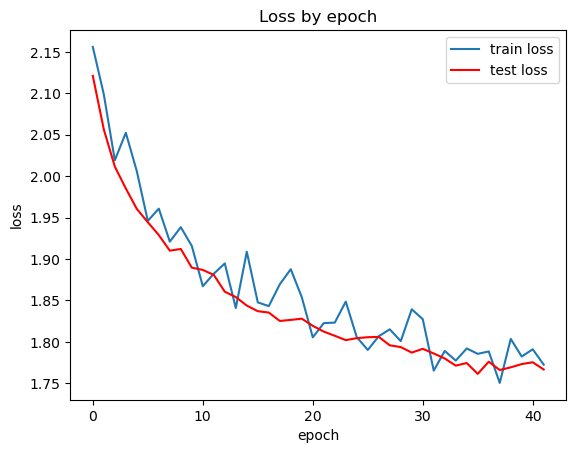

In [37]:

    
# x = train_losses
# y = test_losses
# plt.plot(x,y)
# plt.show()
# epoch = 0

# for epoch in range(99):
   

plt.plot(np.arange(0,42,1), train_losses, label='train loss')
plt.plot(np.arange(0,42,1), test_losses, 'r', label='test loss')
plt.title('Loss by epoch')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()



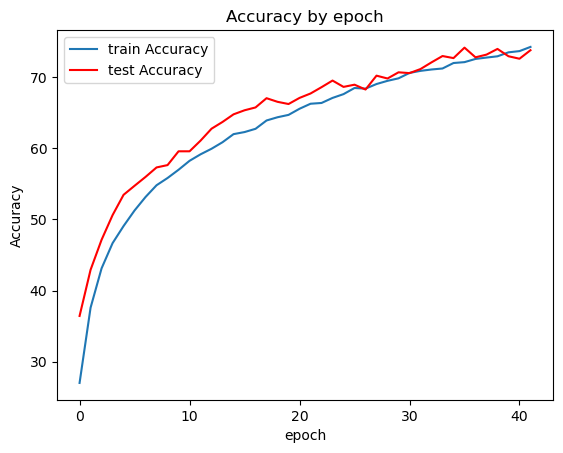

In [38]:
plt.plot(np.arange(0,42,1), train_acc, label='train Accuracy')
plt.plot(np.arange(0,42,1), test_acc, 'r', label='test Accuracy')
plt.title('Accuracy by epoch')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend()